In [800]:
__author__ = 'Knut Olsen <kolsen@noao.edu>, Robert Nikutta <rnikutta@noao.edu>, Stephanie Juneau <sjuneau@noao.edu>' # single string; emails in <>
__version__ = '20171025' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['des_dr1']  # enter used datasets by hand; for a list of available datasets, see cell "Available datasets in Data Lab" further below

## Table of contents
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [First chapter](#chapter1)
* [Resources and references](#resources)

# Dwarf galaxies in DES DR1
In this notebook, we demonstrate the discovery of faint Milky Way dwarf companions in DES DR1.  We query the database around the positions of known dwarfs and apply filtering techniques to reveal the dwarfs as spatial overdensities of filtered sources.

*Knut Olsen, Robert Nikutta, Stephanie Juneau & NOAO Data Lab Team*

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: http://datalab.noao.edu/known-issues.php

<a class="anchor" id="import"></a>
# Imports and setup

In [1]:
# Python 2/3 compatibility
from __future__ import print_function # to use print() as a function in Python 2
#from __future__ import division  # if you need Python 3 division behavior in Python 2

try:
    input = raw_input # use 'input' function in both Python 2 and 3
except NameError:
    pass

# std lib
from getpass import getpass

# 3rd party
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io, convolution, stats
from astropy.visualization import make_lupton_rgb
%matplotlib inline

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers

#SIA
from pyvo.dal import sia
DEF_ACCESS_URL = "http://datalab.noao.edu/sia/des_dr1"
svc = sia.SIAService(DEF_ACCESS_URL)


<a class="anchor" id="auth"></a>
# Authentication

In [2]:
# Python 2/3 compatibility
try:
    input = raw_input
except NameError:
    pass

# Either get token for anonymous user
token = ac.login('anonymous')

# ... or for authenticated user
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))

# Available datasets in Data Lab

In [16]:
qc.set_profile('default')

try:
    print(qc.schema('',format='json',profile='default'))
except Exception as e:
    print(e.message)



     Schema Name   Description
     -----------   -----------
        gaia_dr1   GAIA Data Release 1
            ivoa   IVOA ObsCore tables
        des_sva1   DES SVA1 Data Products
      tap_schema   TAP Schema Tables
         phat_v2   
      decaps_dr1   
          ls_dr5   
     ivoa_ls_dr3   
     ivoa_ls_dr4   
     ivoa_ls_dr5   
    ivoa_des_dr1   
       sdss_dr13   
         dad_dr1   DECam Asteroid Database -- Data Release 1
       smash_dr1   SMASH Data Release 1
            usno   USNO Astrometry Catalogs
         allwise   The AllWISE data release
          ls_dr3   The DECam Legacy Survey Data Release 3.1
          ls_dr4   The DECam Legacy Survey Data Release 3



<a class="anchor" id="chapter1"></a>
# Preface
We're going to select the prototype database and define some functions that we'll use later.


In [26]:
#The pre-release DES DR1 profile
try:
    qc.set_profile('des-proto')
except Exception as e:
    print(e.message)
    
try:
    print(qc.schema('des_dr1',format='json',profile='des-proto'))
except Exception as e:
    print(e.message)



Schema: des_dr1

      Table Name   Description
      ----------   -----------
      complement   Secondary metadata
        exposure   Exposure information
            hpix   HEALPIX tile table
            main   Main object summary table
       neighbors   Objects within 30 arcsec
       tile_info   Tile information table
       galex_des   GALEX crossmatch
         vhs_des   VISTA Hemisphere Survey crossmatch
        wise_des   WISE crossmatch
          band_g   Single-band SExtractor table
          band_i   Single-band SExtractor table
          band_r   Single-band SExtractor table
          band_y   Single-band SExtractor table
          band_z   Single-band SExtractor table
  vac_sextractor   SExtractor summary table



In [6]:
q="""-- This is a comment
SELECT * FROM des_dr1.main LIMIT 10"""

try:
    result = qc.query(token,sql=q) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)


df=(helpers.convert(result))
print(df.columns.values)

Returning Pandas dataframe
['coadd_object_id' 'hpix' 'htm9' 'ring256' 'nest4096' 'pfw_attempt_id'
 'moly_number_g' 'moly_number_r' 'moly_number_i' 'moly_number_z'
 'moly_number_y' 'ra' 'dec' 'alphawin_j2000' 'deltawin_j2000' 'ebv_sfd98'
 'xwin_image' 'ywin_image' 'elon' 'elat' 'l' 'b' 'kron_radius' 'a_image'
 'b_image' 'theta_j2000' 'erra_image' 'errb_image' 'errtheta_image'
 'mag_detmodel_g' 'mag_auto_g' 'mag_aper_8_g' 'wavg_mag_psf_g'
 'magerr_detmodel_g' 'magerr_auto_g' 'magerr_aper_8_g' 'wavg_magerr_psf_g'
 'flux_detmodel_g' 'flux_auto_g' 'wavg_flux_psf_g' 'flux_radius_g'
 'flux_aper_8_g' 'fluxerr_detmodel_g' 'fluxerr_auto_g' 'wavg_fluxerr_psf_g'
 'fluxerr_aper_8_g' 'mu_eff_model_g' 'mu_max_g' 'mu_max_model_g'
 'mu_mean_model_g' 'mu_threshold_g' 'spreaderr_model_g' 'spread_model_g'
 'class_star_g' 'wavg_spreaderr_model_g' 'wavg_spread_model_g'
 'mag_detmodel_r' 'mag_auto_r' 'mag_aper_8_r' 'wavg_mag_psf_r'
 'magerr_detmodel_r' 'magerr_auto_r' 'magerr_aper_8_r' 'wavg_magerr_psf_r'
 '

In [7]:
# a function to retrieve data from a point on the sky
def getData (ra,dec,radius=1.0,columns='*'):

    query_template =\
    """SELECT {0:s} FROM des_dr1.main
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})"""

    query = query_template.format(columns,ra,dec,radius)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.convert(result,'pandas')
    
    return df

In [8]:
# a function to retrieve data from a point on the sky
def getData2 (ra,dec,radius=1.0,columns='*'):

    query_template =\
    """SELECT {0:s} FROM des_dr1.main
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f}) AND fluxerr_auto_g>0"""

    query = query_template.format(columns,ra,dec,radius)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.convert(result,'pandas')
    
    return df

In [9]:
# a simple sky plot
def skyPlot (df,ax):
    
    im=ax.hexbin(df['ra'],df['dec'],gridsize=200)
    
    return im

In [10]:
# a convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    # Based on Koposov et al. (2008).
    # Code by Ken Mighell and Mike Fitzpatrick.
    # Minor edits by RN.
    
    x, y = ra, dec

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max())/2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint (xdiff_angular_arcmin).astype('int')
    ny = np.rint (ydiff_arcmin).astype('int')
    
    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve (raw_hist, kernel_big)
    conv_small = convolution.convolve (raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean (delta, dtype='float64')
    sigma = np.std (delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median (delta)                       # not used
    floor = mean 

    # Clip to specified limits.
    clipped = delta.copy()
    clipped[ delta < floor ] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [11]:
# a little function to download the deepest stacked images
# adapted from R. Nikutta
def download_deepest_image(ra,dec,fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains", len(imgTable), "entries")
    
    sel0 = imgTable['obs_bandpass'].astype(str)==band
    sel = sel0 & ((imgTable['proctype'].astype(str)=='Stack') & (imgTable['prodtype'].astype(str)=='image')) # basic selection
    Table = imgTable[sel] # select
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'].decode() # get the download URL
        print ('downloading deepest stacked image...')
        image = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))

    else:
        print ('No image available.')
        image=None
        
    return image

# multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        if img is not None:
            print(img.min(),img.max())
            ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=img.max()))
            ax.set_title('%s band' % bands[j])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
                
            

# Chapter 1 -- Photometry containing dwarfs
We take the positions of the first eight dwarf galaxies and query the database around them.

In [12]:
# Locations of Dwarfs from Bechtol et al. (2015)
ra=[53.92,56.090,343.06,43.87,317.20,70.95,354.99,35.69]
dec=[-54.05,-43.530,-58.57,-54.11,-51.16,-50.28,-54.41,-52.28]
name=['RetII','EriII','TucII','HorI','IndI','PicI','PheII','EriIII']
radius=1. # degrees
columns='''ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,flags_g,flags_i,flags_r,flags_z,
    flux_auto_g,fluxerr_auto_g,flux_auto_i,fluxerr_auto_i,spread_model_g,spread_model_i,
    spread_model_r,spread_model_z,class_star_g,class_star_i,class_star_r,class_star_z,
    kron_radius,tilename'''
df_dict = {dwarf: pd.DataFrame() for dwarf in name}

In [13]:
%%time
for i in range(len(ra)):
    ra1=ra[i]
    dec1=dec[i]
    name1=name[i]
    df=getData(ra1,dec1,radius=radius,columns=columns)
    df_dict[name1]=df

SELECT ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,flags_g,flags_i,flags_r,flags_z,
    flux_auto_g,fluxerr_auto_g,flux_auto_i,fluxerr_auto_i,spread_model_g,spread_model_i,
    spread_model_r,spread_model_z,class_star_g,class_star_i,class_star_r,class_star_z,
    kron_radius,tilename FROM des_dr1.main
       WHERE q3c_radial_query(ra,dec,53.920000,-54.050000,1.000000)
Returning Pandas dataframe
SELECT ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,flags_g,flags_i,flags_r,flags_z,
    flux_auto_g,fluxerr_auto_g,flux_auto_i,fluxerr_auto_i,spread_model_g,spread_model_i,
    spread_model_r,spread_model_z,class_star_g,class_star_i,class_star_r,class_star_z,
    kron_radius,tilename FROM des_dr1.main
       WHERE q3c_radial_query(ra,dec,56.090000,-43.530000,1.000000)
Returning Pandas dataframe
SELECT ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_z,flags_g,flags_i,flags_r,flags_z,
    flux_auto_g,fluxerr_auto_g,flux_auto_i,fluxerr_auto_i,spread_model_g,spread_model_i,
    spread

# Chapter 2 -- Filtering and plotting the dwarfs
We filter the photometry to include objects without SE flags, S/N>5, that are point-like (using SPREAD_MODEL, CLASS_STAR, and KRON_RADIUS--see the notebook StarGalQsoDESDR1 for details), and that are relatively blue (*g-i* < 1.0).  We convolve the result with the spatial filter defined above.

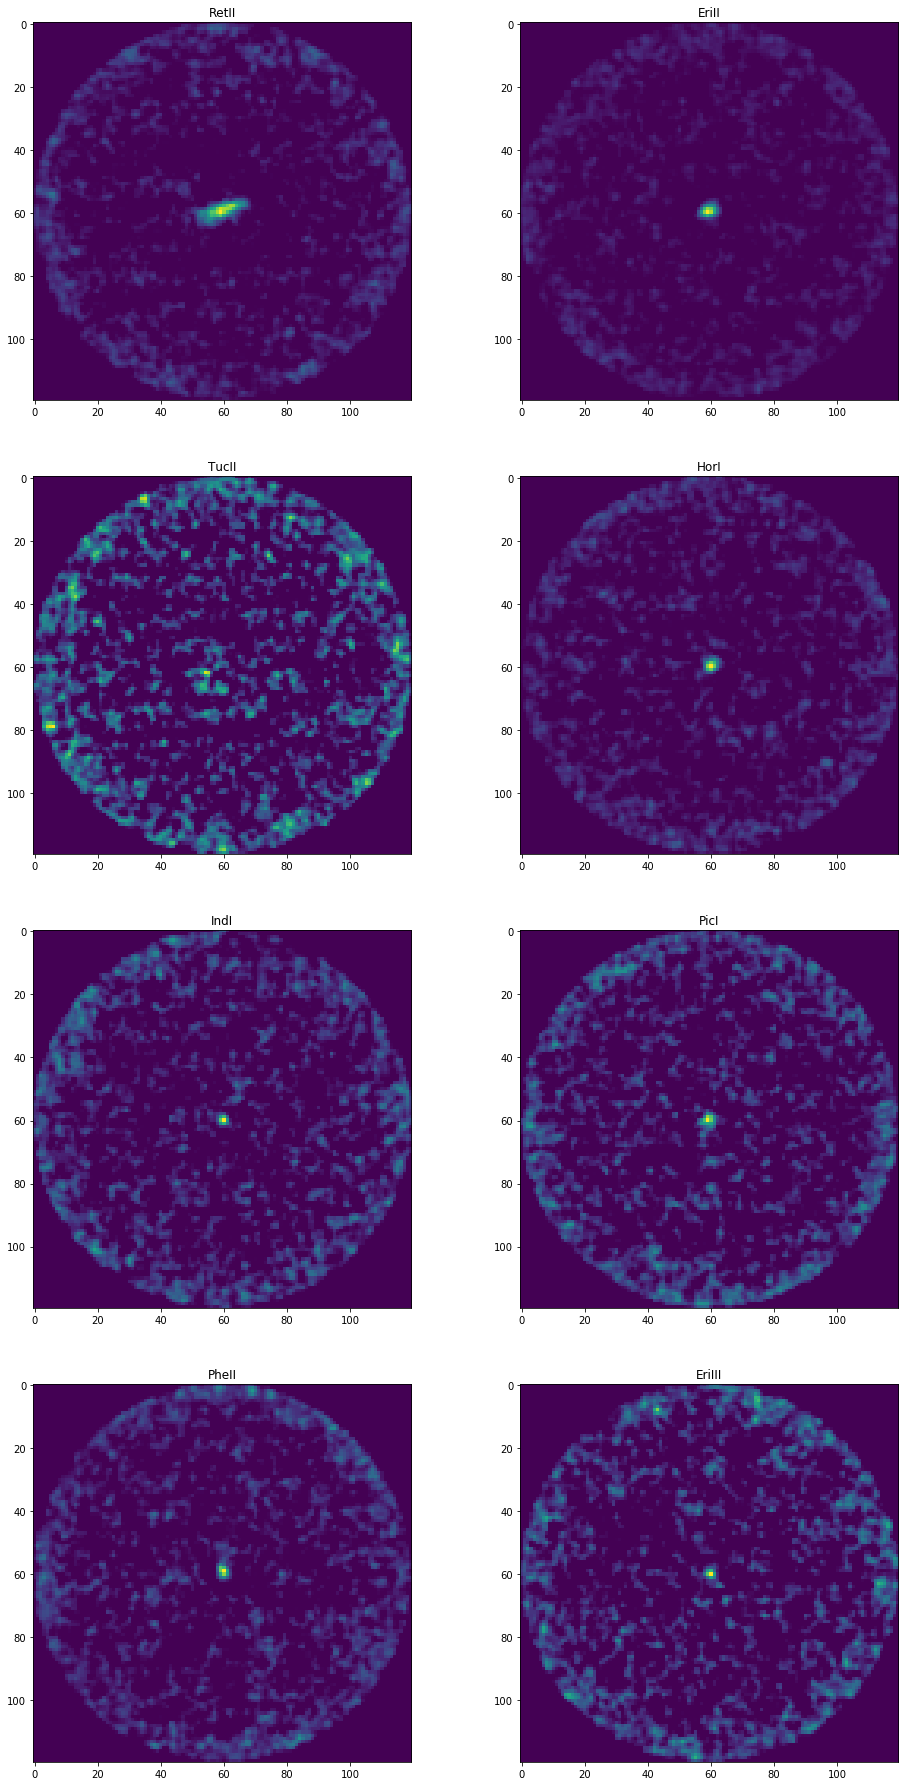

In [22]:
#df_dict2=df_dict
nrow=4
ncol=2
fig = plt.figure(figsize=(8*ncol,8*nrow))
j=0
for name in df_dict:
    df=df_dict[name]
    keep=(df['mag_auto_g']<90) & (df['mag_auto_i']<90) & (df['flags_g']==0) & \
        (df['flags_i']==0) & ((df['flux_auto_g']/df['fluxerr_auto_g'])>5) & \
        ((df['mag_auto_g']-df['mag_auto_r'])<1.0) & (np.abs(df['spread_model_g'])<0.01) & \
        (np.abs(df['spread_model_i'])<0.01) & (df['class_star_g']>0.1) & \
        (df['kron_radius']<6) & (df['mag_auto_g']>18) & ((df['mag_auto_g']-df['mag_auto_r'])>(-0.5))
    df2=df[keep]
    raw_hist, extent, delta, clipped, sigma=dwarf_filter(df2['ra'],df2['dec'])
    #skyPlot(df2,ax)
    ax=fig.add_subplot(nrow,ncol,j+1)
    im=plt.imshow(clipped)
    ax.set_title(name)
    j=j+1

# Chapter 3 -- Retrieve images
We demonstrate how to retrieve images though the SIA service.

In [19]:
star=df[(np.abs(df['spread_model_g'])<0.01)]
len(star)

144494

In [20]:
band = 'g'
rac=ra[7]
decc=dec[7]

gimage = download_deepest_image(rac, decc, fov=0.1, band=band) # FOV in deg
band = 'r'
rimage = download_deepest_image(rac, decc, fov=0.1, band=band) # FOV in deg
band = 'i'
iimage = download_deepest_image(rac, decc, fov=0.1, band=band) # FOV in deg
images=[gimage,rimage,iimage]

The full image list contains 18 entries
downloading deepest stacked image...


The full image list contains 18 entries
downloading deepest stacked image...
The full image list contains 18 entries
downloading deepest stacked image...


In [21]:
print(rac,decc)

35.69 -52.28


-15.6462 10880.2
-22.7218 12955.4
-40.6913 26623.6


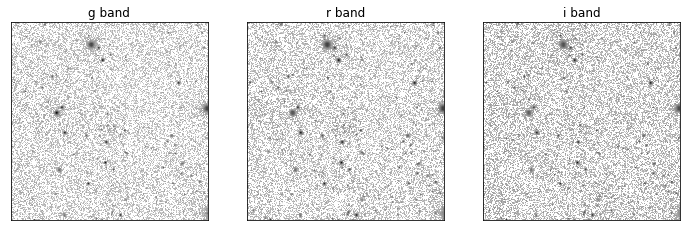

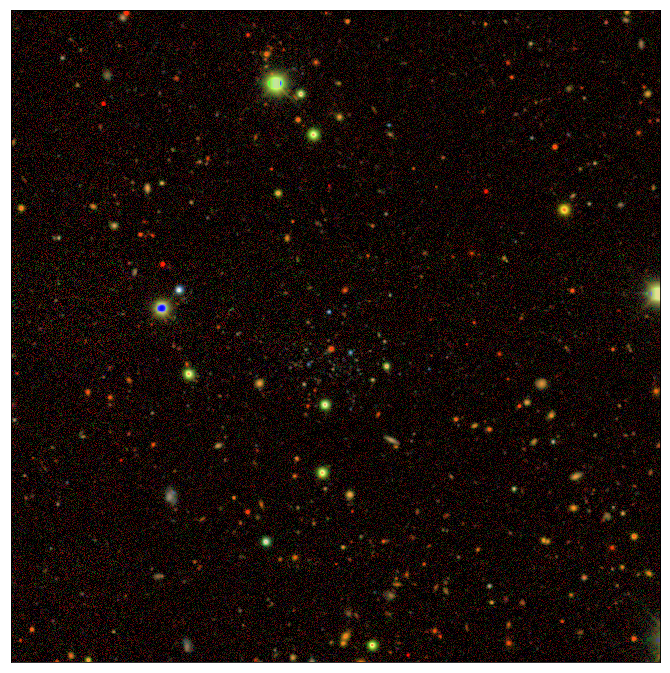

In [25]:
img = make_lupton_rgb(iimage, rimage, gimage, stretch=30)
plot_images(images)

fig = plt.figure(figsize=[12,12])
ax = fig.add_subplot(1,1,1)

ax.imshow(img,origin='lower')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


<a class="anchor" id="resources"></a>
## Resources and references

Bechtol, K., et al. (2015, ApJ, 807, 50) "Eight New Milky Way Companions Discovered in First-year Dark Energy Survey Data":
http://adsabs.harvard.edu/abs/2015ApJ...807...50B

Koposov et al. (2008, ApJ, 686, 279) "The Luminosity Function of the Milky Way Satellites": http://adsabs.harvard.edu/abs/2008ApJ...686..279K
